# Retrieval 101 

## PICASO Retrieval Philosophy: How is this "retrieval" code different from others? 

A "retrieval" is a word we use to describe the coupling of a forward model (e.g. picaso) with a statistical sampler (e.g. ultranest, dynesty, pymultinest) in order to conduct spectral inference -- getting constraint intervals for physical parameters. Check out this [great Bayesian workflow tutorial](https://johannesbuchner.github.io/UltraNest/example-sine-bayesian-workflow.html) which shows the simple exercise of setting up a "retrieval" for a sine model with gaussian measurement errors. An atmospheric retrieval is very similar to this example, as we will show below. The major difference being, of course, the use of an atmospheric model in place of the simple sine curve. 

The main difference between PICASO and other codes is that PICASO's retrieval code is much more stripped down. You will see much more similarity between the tutorials that follow below, and the tutorials on the websites of the statistical samplers themselves. 

**Cons:** if you want more of a "plug and play" approach to retrieving atmospheric properties, this is probably not the code for you and something like [POSEIDON](https://poseidon-retrievals.readthedocs.io/en/latest/content/notebooks/retrieval_basic.html#Creating-a-Retrieval-Model) might be a quicker setup for you. **Pros:** if you want to learn how to write your own parameterizations and retrieval setups, then this route might be good for you. We will walk you through setting up several flavors of retrievals (grid only, grids+post processing, fully free retrivals). After you learn the basics, we will introduce some of our autobuild tools for writing scripts. 

## Making sense of grid fits, gridtrievals, free retrievals

The graphic below should help clarify the difference between these different spectral inference schemes. In order to create a spectra that we can compare to data, we need as input: planet/stellar parameters, a pressure-temperature profile, and set of chemical abundances as a function of pressure. The major difference between these three setups is in how you create the input. We can either use a set of radiative-convective models to pre-compute pressure-temperature and chemistry. Or, we can set up simple parameterizations (e.g., could be as simple as an isothermal line) to build these inputs. The "magic sauce" of retrievals is all in how we build these parameterizations. 

![image](retrievalfig/retrievalfig.001.jpeg) 

<div class="alert alert-block alert-info">
^ Image link is broken.
</div>

## Retrieval Tutorial Overview

Our full retrieval tutorial takes you through: 

1. The basics of our retrievals workflow: the data, the model set, the prior set, the likelihood function (**this tutorial**)
2. The basics of a retrieval analysis: corner plots, Bayesian evidence, 1-3 sigma banded spectra (**this tutorial**)
3. Implemenation: Grid Fitting -- Using only pre-computed grids to get best fit grid values
4. Implementation: Grid-trieval -- Using a pre-computed grid and post-processing values such as clouds, added chemistry, etc.
5. Implementation: Free retrieval -- Building parameterizations 

All of these retrieval tutorials are done using the [WASP-17 b Grant et al data](https://zenodo.org/records/8360121) and an associated pre-computed PICASO model grid. 

<div class="alert alert-block alert-info">
Here are the resources I used to fill in the background/context:

["Bayesian Workflow" from UltraNest](https://johannesbuchner.github.io/UltraNest/example-sine-bayesian-workflow.html) (as you suggest above) - This was the most relevant resource, but it didn't really explain the Bayesian workflow; rather, it just applied the workflow to an exoplanet problem, so I didn't understand it at first. After you and I discussed how to select good priors, how to transform a cube, why you want to make a flipbook of your priors, how to run a sampler to make posteriors, and why you do a posteriors predictive check... then I came back to this link and it all made sense.

[Youtube "Crash Course Statistics #24"](https://www.youtube.com/watch?v=9TDjifpGj-k) - Although cheesy and unrelated to astro, this video did a great job explaining the basic idea behind Bayesian statistics: how it allows you to update your beliefs based on prior knowledge. Posteriors = priors * likelihood, where posteriors are what you believe after you've seen the evidence, priors are what you believed before you saw the evidence, and likelihood is how much your evidence should change your prior belief. It also covers how to compare two hypotheses and get a Bayes factor.

[Astrobites "Your Gateway to the Bayesian Realm"](https://astrobites.org/2011/11/26/your-gateway-to-the-bayesian-realm/) - Unfortunately this was a bit hard to follow given the missing control sequences.

[ArXiv "Visualization in Bayesian workflow"](https://arxiv.org/abs/1709.01449) - Pg 1-5 conceptually worked through a fine example of how to (a) explore data to make sure you don't fall into Simpson's paradox and (b) why you visualize your priors to make sure they adequately capture the data. Pg 6 onward goes into different visualization techniques for examining your posteriors, which lost me. (Though pg 8 makes the good point that posterior predictive checks are important to ensure sure your model can generate fake data that looks like the real data.)

</div>

# The Basics of Retrieval Workflow

All PICASO retrieval scripts will include at least: 

1. function `get_data` : a function to get your spectral data
2. class `param_set` : a class that contains the set of free parameters you want to retrieve
3. class `guesses_set` : an option class that will help you test your models 
4. class `model_set` : a class that contains the set of models you want to test
5. class `prior_set` : a class that defines the prior
6. function `loglikelihood` : a function that calls your model and computes the likelihood 
7. statistical sampling run script : code that executes the sampler (e.g. UltraNest)

Below we break these down with the simple function of fitting a line to a spectrum. If you understand the basics here of fitting some model to a spectrum, and analyzing the results, you will be well positioned to move on to the next tutorials where we swap the simple line function for a PICASO function.

In [18]:
import numpy as np
import os 
import picaso.justdoit as jdi
import picaso.analyze as lyz
import xarray as xr
import matplotlib.pyplot as plt

## Step 1) Develop function to get data

Let's create a function to pull our data where all we need to do is declare who the data is from and it pulls it for us automatically.

Note: this format is only a recommendation and you can change any part of this to fit your needs.

In [19]:
def get_data(): 
    """
    Create a function to process your data in any way you see fit.
    Here we are using the ExoTiC-MIRI data 
    https://zenodo.org/records/8360121/files/ExoTiC-MIRI.zip?download=1
    But no need to download it.

    Checklist
    ---------
    - your function returns a spectrum that will be in the same units as your picaso model (e.g. rp/rs^2, erg/s/cm/cm or other) 
    - your function returns a spectrum that is in ascending order of wavenumber 
    - your function returns a dictionary where the key specifies the instrument name (in the event there are multiple)

    Returns
    -------
    dict: 
        dictionary key: wavenumber (ascending), flux or transit depth, and error.
        e.g. {'MIRI LRS':[wavenumber, transit depth, transit depth error], 'NIRSpec G395H':[wavenumber, transit depth, transit depth error]}
    """
    dat = xr.load_dataset(jdi.w17_data())
    #build nice dataframe so we can easily view the data
    final = jdi.pd.DataFrame(dict(wlgrid_center=dat.coords['central_wavelength'].values,
                transit_depth=dat.data_vars['transit_depth'].values,
                transit_depth_error=dat.data_vars['transit_depth_error'].values))

    #create a wavenumber grid 
    final['wavenumber'] = 1e4/final['wlgrid_center']

    #always ensure we are ordered correctly
    final = final.sort_values(by='wavenumber').reset_index(drop=True)

    #return a nice dictionary with the info we need 
    returns = {'MIRI_LRS': [final['wavenumber'].values, 
             final['transit_depth'].values ,final['transit_depth_error'].values]}
    return returns

## Step 2) Define Free Parameters

In what follows we build three classes that will (in the future) help us keep track of all the models we test for a single planet case. For this simple tutorial, let's just do the simplest thing and retrieve the simplest model possible: 

$$y = mx + b$$

In [20]:
class param_set:
    """
    This is for book keeping what parameters you have run in each retrieval.
    It helps if you keep variables uniform.
    
    Checklist
    ---------
    - Make sure that the order of variables here matches how you are unpacking your cube in the model_set class and prior_set
    - Make sure that the variable names here match the function names in model_set and prior_set
    """
    line=['m','b','log_err_inf'] 


<div class="alert alert-block alert-info">

^ If we were testing, say, 3 models, we would define the relevant params for all three models in here... so instead of just having `line=`, we'd have `M1=`, `M2=`, and `M3=`.

</div>

## Step 3) Define Initial Guesses

In testing, it is very useful to check that it is grabbing the right parameters before doing a full analysis. Also if you choose to use MCMC instead of MultiNest, these can serve as your starting values for your chain. 

In [21]:
class guesses_set: 
    """
    Optional! 

    Tips
    ----
    - Usually you might have some guess (however incorrect) of what the answer might be. You can use this in the testing phase!
    """
    line=[0,0.016633,-1] #here I am guessing a zero slope, and the measured transit depth reported from exo.mast, and a small error inflation term

## Step 4) Define Model Set

Here, we are defining the full model. This is essentially prepping and making it easy to digest for UltraNest's `cube` usage.

In [22]:
class model_set:
    """
    This is your full model set. It will include all the functions you want to test
    for a particular data set.

    Tips
    ----
    - if you keep the structure of all your returns identically, you will thank yourself later. 
      For example, below I always return x,y,dict of instrument offsets,dict of error inflation, if exists

    Checklist
    ---------
    - unpacking the cube should unpack the parameters you have set in your param_set class. I like to use 
    list indexing with strings so I dont have to rely on remembering a specific order
    """     
    def line(cube): 
        wno_grid = np.linspace(600,3000,int(1e4)) #in the future this will be defined by the picaso opacity db
        m = cube[param_set.line.index('m')] 
        b = cube[param_set.line.index('b')] 
        err_inf = {'MIRI_LRS':10**cube[param_set.line.index('log_err_inf')] }
        y = m*wno_grid + b 
        offsets = {} #I like to keep the returns of all my model sets the same 
        return wno_grid,y,offsets,err_inf

<div class="alert alert-block alert-info">

When using multiple instruments, often we find that the spectra will be offset (one rests higher on the y-axis than the other) for some reason. So for each pair of instrument you introduce, you may want to include an `offsets` term that will indicate the amount by which you need to shift the data up or down from one instrument to align it with the other.

Additionally, each instrument has its own systematic errors. So you may want to introduce an `err_inf` term for each instrument you include, in order to lump together those systematic instrument errors and account for them.

`err_inf` and `offsets` are initiated as dictionaries so they can hold multiple values, one assigned to each instrument. In this example, we only have one instrument (`'MIRI_LRS'`), so we only have one error associated with that instrument, which we grab from `param_set`. And since there is no second instrument to compare to, we don't have any offsets (thus `offsets = {}` is an empty dictionary).

</div>

## Step 5) Define Prior Set

Finally, we are storing all the priors for UltraNest to use.

In [23]:
class prior_set:
    """
    Store all your priors. You should have the same exact function names in here as
    you do in model_set and param_set.

    Checklist
    ---------
    - Make sure the order of the unpacked cube follows the unpacking in your model 
      set and in your parameter set. 
    """   
    def line(cube):#,ndim, nparams):
        params = cube.copy()
        #slope min max
        min = -1e-5
        max = 1e-5
        i = param_set.line.index('m')
        params[i] = min + (max-min)*params[i]
        #intercept min max
        min = 0.015
        max = 0.02
        i = param_set.line.index('b')
        params[i] = min + (max-min)*params[i]
        #log err inflation min max 
        min = -10
        max = 3
        i = param_set.line.index('log_err_inf')
        params[i] = min + (max-min)*params[i]
        return params                


<div class="alert alert-block alert-info">

If I'm understanding correctly, what's happening here is...

`cube` has been generated prior to calling this function, using `cube=np.random.uniform(size=len(PARAMS))`, which creates an array of 3 numbers (one for each of our 3 parameters), where each number is randomly selected from the closed interval [0, 1].

`prior_set(cube)` takes the cube value corresponding to the index of `m` (here, 0) and transforms it according to the prior range that has been set for `m`. It repeats the process with the cube value corresponding to `b` (index 1) and `log_err_inf` (index 2), transforming them according to the appropriate prior ranges.

For example: if cube returned three random numbers [0.1, 0.5, 0.2] between 0 and 1, the 0th value (0.1) would correspond to `m`. If the prior for `m` was [-5, 5], then `prior_set(cube)` would calculate what 10% of the [-5, 5] interval would be (-4) and would return that as the new value for `m`. Following this line of thinking, if `b`'s prior was [-10,10], and `log_err_inf`'s prior was [0,1], then `prior_set(cube)` would return the transformed values of [-4, 0, 0.2].

</div>

## Step 6) Define Likelihood Function

Most likelihood functions have the same form (see for example the formalism in [emcee](https://emcee.readthedocs.io/en/stable/tutorials/line/#maximum-likelihood-estimation)). 

In [24]:
def loglikelihood(cube):
    """
    Log_likelihood function that ultimately is given to the sampler.
    Note if you keep to our same formats, you will not have to change this code more.

    Tips
    ----
    - Remember how we put our data dict, error inflation, and offsets all in dictionary format? 
    Now we can utilize that functionality if we properly named them all with the right keys! 

    Checklist
    --------- 
    - ensure that error inflation and offsets are incorporated in the way that suits your problem 
    - note there are many different ways to incorporate error inflation! this is just one example 
    """
    #compute model spectra
    resultx,resulty,offset_all,err_inf_all = MODEL(cube) # we will define MODEL below 

    #initiate the four terms we will need for the likelihood
    ydat_all=[];ymod_all=[];sigma_all=[];extra_term_all=[];

    #loop through data (if multiple instruments, add offsets if present, add err inflation if present)
    for ikey in DATA_DICT.keys(): #we will also define DATA_DICT below
        xdata,ydata,edata = DATA_DICT[ikey]
        xbin_model,y_model = jdi.mean_regrid(resultx, resulty, newx=xdata)#remember we put everything already sorted on wavenumber

        #add offsets if they exist
        offset = offset_all.get(ikey,0) #if offset for that instrument doesn't exist, return 0
        ydata = ydata+offset 

        #add error inflation if they exist
        err_inf = err_inf_all.get(ikey,0) #if err inf term for that instrument doesn't exist, return 0
        sigma = edata**2 + (err_inf)**2 #there are multiple ways to do this, here just adding in an extra noise term
        if err_inf !=0: 
            #see formalism here for example https://emcee.readthedocs.io/en/stable/tutorials/line/#maximum-likelihood-estimation
            extra_term = np.log(2*np.pi*sigma)
        else: 
            extra_term=sigma*0

        ydat_all.append(ydata);ymod_all.append(y_model);sigma_all.append(sigma);extra_term_all.append(extra_term); 

    ymod_all = np.concatenate(ymod_all)    
    ydat_all = np.concatenate(ydat_all)    
    sigma_all = np.concatenate(sigma_all)  
    extra_term_all = np.concatenate(extra_term_all)

    #compute likelihood
    loglike = -0.5*np.sum((ydat_all-ymod_all)**2/sigma_all + extra_term_all)
    return loglike

<div class="alert alert-block alert-info">
    
Why do the regridding? Remember, the model was computed at a higher resolution than the data. But now we need them to match each other 1:1. So we regrid the model so that it has the same x-values as the data.

</div>

## Step 7) Check models, likelihoods, priors! 

Do not undersestimate the importance of this step before moving forward. You always want to ensure that your model is returning sensible values before you jump into running your sampler. 

Ask yourself: 

1. Do your random tests about your prior approximately go through the data?
2. Do they seem skewed? If so, maybe you need to adjust your prior?
3. Do the likelihood values track with the models? E.g. lower likelihoods for bad models, higher likelihoods for good models 

<div class="alert alert-block alert-info">
    
If you set your priors too wide, the sampler will waste time exploring useless regions. If you set your priors too narrow, you’re forcing the desired answer.

That’s why you test your priors (by picking a bunch of example points and making sure the sampled regions cover where the data falls, not too narrowly, not too widely). You want to ensure your prior space will capture the data, including some outlying regions that are still within the realm of plausibility.

In the field of exoplanets, we often don’t have prior info. So we set wide noninformative priors that are very broad (e.g., temp could be anything from 500 – 5,000 K with equal probability).
</div>

In [25]:
#we can easily grab all the important pieces now that they are neatly stored in a class structure 
DATA_DICT = get_data()
PARAMS = getattr(param_set,'line')
MODEL = getattr(model_set,'line')
PRIOR = getattr(prior_set,'line')
GUESS = getattr(guesses_set,'line')

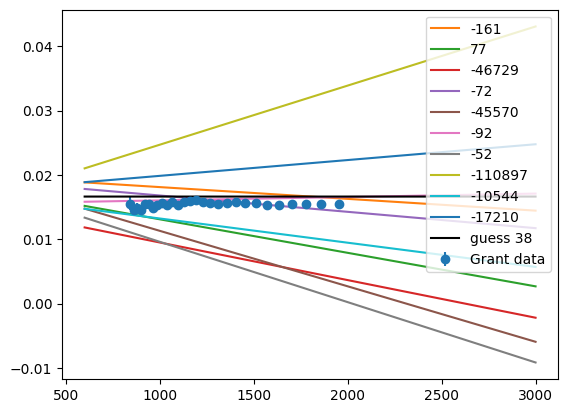

In [26]:
import matplotlib.pyplot as plt
plt.figure()
#let's plot the data 
for ikey in DATA_DICT.keys(): 
    plt.errorbar(x=DATA_DICT[ikey][0], y=DATA_DICT[ikey][1], yerr=DATA_DICT[ikey][2], marker='o', ls=' ', label='Grant data')

ntests = 10 #let's do 10 random tests 
for i in range(ntests): 
    cube = np.random.uniform(size=len(PARAMS))
    params_evaluations = PRIOR(cube)
    x,y,off,err = MODEL(params_evaluations)
    loglike = loglikelihood(params_evaluations)
    plt.plot(x,y,label=str(int(loglike)))

guessx,guessy,off,err = MODEL(GUESS)
guess_log = loglikelihood(GUESS)
plt.plot(guessx,guessy,color='black',label='guess '+ str(int(guess_log)))
plt.legend()

<div class="alert alert-block alert-info">

    for i in range(ntests): 
        cube = np.random.uniform(size=len(PARAMS))
        params_evaluations = PRIOR(cube)
        x,y,off,err = MODEL(params_evaluations)
        loglike = loglikelihood(params_evaluations)
        plt.plot(x,y,label=str(int(loglike)))

^ So what this code is doing is...
- repeat the following steps n=10 times
    - generate an array ("cube") of random numbers between 0 and 1, one value for each parameter
    - transform the values in the cube according to the ranges allowed for each prior, giving you your parameter values
    - plug this set of parameter values into your model equation and evaluate
    - grab the outputs and save them as variables x, y, off, err
    - calculate the log likelihood of this model and save it in the variable loglike
    - plot the model (x vs. y)

</div>

Looks pretty good! We might be tiny bit skewed toward higher y intercept values but overall things look good. 

<div class="alert alert-block alert-info">
    
Ideally, lines with high likelihood values (see legend) should better represent that data. You might notice that this is not always the case in this plot. This is probably an effect of including the log_err_inf term, which is not pictured. So it's possible that a line could be far away from the data, but have such huge error bars that it appears to overlap with the data, and thus it might receive a higher likelihood score than you'd expect. This makes the plot rather misleading...

</div>

## Step 8) Run the statistical sampler!! 

Now we can finally move forward with running UltraNest. Though, once you have gotten this far, you will have the skills to implement other samplers as well. They all generally have the same format.

In [27]:
import ultranest

In [28]:
sampler = ultranest.ReactiveNestedSampler(PARAMS, loglikelihood, PRIOR)
result = sampler.run()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=2e+02  9 [191.8757..191.8758]*| it/evals=5640/16827 eff=34.3337% N=400 00 0 0 
[ultranest] Likelihood function evaluations: 16831
[ultranest]   logZ = 182.4 +- 0.1049
[ultranest] Effective samples strategy satisfied (ESS = 1658.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.


<div class="alert alert-block alert-info">

You might explain here how the sampler works...

It samples some number of “live points” from within the defined prior-space (in this case, it is making 400 random cubes, which are each transformed by `prior_set(cube)` into 400 sets of param values within prior-space) and calculates the log likelihood for each line.

Then it rules out the worst likelihood points and draws a new ellipse that represents the new sub-region of the prior-space it will draw samples from.

Repeats over and over, drawing smaller and smaller ellipses, until it can’t eliminate any more points because the likelihoods are all the same.

The number of live points should be ~50x the number of parameters, so the prior-space gets adequately sampled.

At the end, it will give you the best value for each parameters with a +/- range representing a given confidence interval.

We can see in this example that `m` and `b` are well constrained, but there are a large range of `log_err_inf` values that fit the data, so that parameter is not well constrained.
</div>

# The Basics of Retrieval Analysis

In future tutorials you will see some pre-defined functions to help you with doing the following analyses. However, on a first go-around in this simple example, we will put the native code here so you can see what is going on under the hood. 

## Posterior predictive checks

First let us check that our samples are returning a sensible model for our data. 

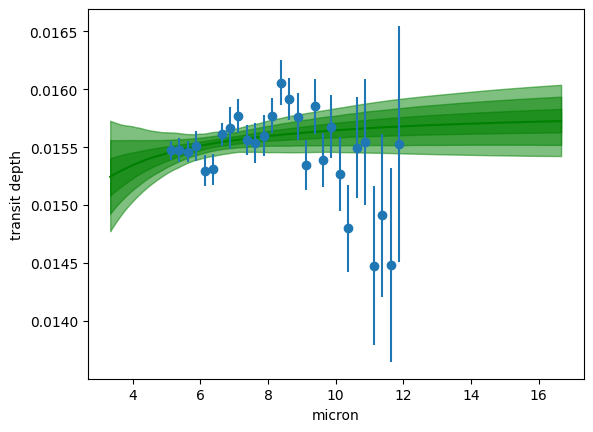

In [29]:
from ultranest.plot import PredictionBand

plt.figure()
first = True
for params in result['samples']:
    x,y,off,err = MODEL(params)
    if first:
        band = PredictionBand(1e4/x);first=False   #transforming xaxis to microns 
    band.add(y)

band.line(color='g') #median model

#lets plot the 1, 2, and 3 sigma confidence interval from these samples 
for q, key in zip([k/100/2 for k in [68.27, 95.45, 99.73]], ['1sig','2sig','3sig']): 
        band.shade(q=q, color='g', alpha=0.5)

for ikey in DATA_DICT.keys(): 
    plt.errorbar(x=1e4/DATA_DICT[ikey][0], y=DATA_DICT[ikey][1], yerr=DATA_DICT[ikey][2], marker='o', ls=' ', label='Grant data')
    
plt.xlabel('micron')
plt.ylabel('transit depth');

<div class="alert alert-block alert-info">

^This plot draws green regions on the graph representing the best solution’s 1-sigma, 2-sigma, and 3-sigma confidence intervals. The broad region to the left is poorly constrained because there are no data points, and the broad region to the right is poorly constrained because the data points have large uncertainties. The middle section is tightly constrained by the data, so those data points are having the biggest impact on the model.

</div>

Not bad! We are nearly ready to implement a real atmosphere model to fit the data! 


## Parameter posterior probability distribution checks

What to check for in a corner plot: 

1. Are your 1D marginalized posterior probability distributions Gaussian (bell shaped)?
2. Are there correlations between your parameters?
3. Does your posterior probability distribution hit the limit of your prior (check the x axis of each distribution)?

For our example below: m and b appear Gaussian. However, the error inflation term looks to be poorly constrained. We only have an upper limit on the number. 

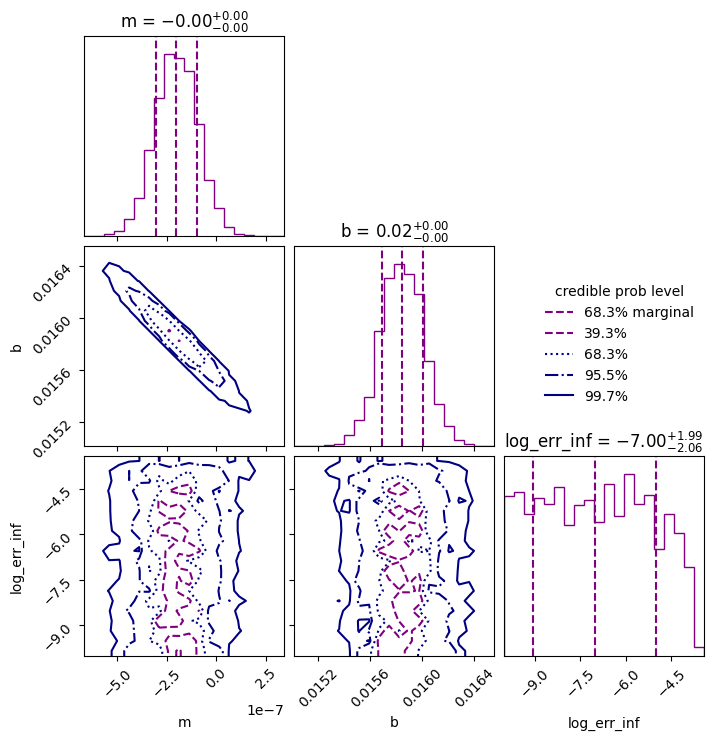

In [30]:
from ultranest.plot import cornerplot
p=cornerplot(result)

<div class="alert alert-block alert-info">
    
^ Ideally you’d like to see a bullseye circular cluster of points, and a gaussian distribution for each parameter. 

However, what we have shows that `m` and `b` are dependent variables because the points are clustered in a line, not a circle, meaning if you vary `b`, you’ll also vary `m`. 

The `log_error_inf` appears unconstrained and it doesn’t appear to be driving to any of the other values, so if you like, you could exclude it in your next model to reduce the number of extraneous parameters.

</div>

## Exercise to check your understanding 

1. Go back through param_set, prior_set and try rerunning the retrieval that does not include the error inflation term. 

TIP: Rather than changing the line model, add a new model called line_noerrinf. If you follow the formalism you will not have to change the likelihood code. You should only have to make edits to the param_set, model_set, and prior_set (and guesses_set if you are using this to check your model).

<div class="alert alert-block alert-info">

<details>
  <summary><b>Answer</b></summary>
    
- Add `line_noerrinf = ['m','b']` to `class param_set`
- Add `line_noerrinf = [0,0.016633]` to `class guesses_set`
- Set `err_inf={}` as an empty dictionary in `class model_set`
- In `def line(cube)` under `class prior_set`, don't assign the third prior. Delete:

      #log err inflation min max 
      min = -10
      max = 3
      i = param_set.line.index('log_err_inf')
      params[i] = min + (max-min)*params[i]

From here, you could compute the Bayes factor comparing your two models (line & line_noerrinf) to figure out which is favored.
  
</details>
    
</div>

# Short cut to get grid fitting retrieval template in script form 

Now that you understand the basics of running a simple line model let's introduce some PICASO tools to help you quickly setup a new retrieval script, without the hassle of a notebook.

In [31]:
import picaso.retrieval as pr

In [33]:
rtype='line' #first lets specify the retrieval type 'line' (we will introduce the other options in future tutorials)
sript_name='run_test.py' #specify a script name
#sampler_output = '/data/test/ultranest/line' #what folder do you want your ultranest output to go to? 
sampler_output = '../picaso_data/test/ultranest/line' ##### REWA'S FOLDER #####
pr.create_template(rtype,sript_name,sampler_output)

<div class="alert alert-block alert-info">
    
^ Did you mean `script_name` instead of `sript_name`?

Small typos found in run_test.py:
- line 43 (returns)
- line 49 (ascending)
- line 54 (so we can easily view the data)
- line 97 (line should have only 3 values)
- line 110 (example)

</div>

Open up `run_test.py` and modify what you need. We have marked key areas you might want to modify with "CHANGEME"

Running with mpiexec with 5 cpu: 

    >> mpiexec -n 5 python -m mpi4py run_test.py

## Further Reading

https://johannesbuchner.github.io/UltraNest/example-sine-bayesian-workflow.html